In [5]:
# =============================================================================
# GFT (Reference Architecture) Training Script for MelSpectrograms
#
# This script uses the EXACT GFT model architecture from the COCO example,
# but is adapted to use a standard ImageFolder dataset.
# Key dependency: timm (`pip install timm`)
# =============================================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from timm import create_model
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# =============================================================================
# 1. MODEL ARCHITECTURE (EXACTLY as in the reference)
# =============================================================================
class HierarchicalAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        # Smoothing conv layer for spatial gradient
        self.smooth = nn.Conv1d(1, 1, kernel_size=3, padding=1, bias=False)
        nn.init.ones_(self.smooth.weight)
        
        # Exponential Moving Average for stabilizing scores during training
        self.ema_alpha = 0.9
        self.register_buffer('ema_grad', None, persistent=False)

    def compute_gradient_attention(self, attn_scores):
        B, H, N, _ = attn_scores.shape
        mean_attn = attn_scores.mean(dim=-1)
        grad = torch.zeros_like(mean_attn)
        grad[:, :, 1:-1] = (mean_attn[:, :, 2:] - mean_attn[:, :, :-2]) / 2.0
        grad[:, :, 0] = mean_attn[:, :, 1] - mean_attn[:, :, 0]
        grad[:, :, -1] = mean_attn[:, :, -1] - mean_attn[:, :, -2]

        importance_scores = grad.abs().mean(dim=1)
        importance_scores = self.smooth(importance_scores.unsqueeze(1)).squeeze(1)

        # Normalize scores
        importance_scores = (importance_scores - importance_scores.mean(dim=-1, keepdim=True)) / \
                            (importance_scores.std(dim=-1, keepdim=True) + 1e-6)

        if self.training:
            if self.ema_grad is None or self.ema_grad.shape != importance_scores.shape:
                self.ema_grad = importance_scores.detach()
            else:
                self.ema_grad = self.ema_alpha * self.ema_grad + \
                                (1 - self.ema_alpha) * importance_scores.detach()
            importance_scores = 0.5 * (importance_scores + self.ema_grad)

        # Final softmax with temperature scaling
        importance_scores = torch.softmax(importance_scores / 0.1, dim=-1)
        return importance_scores

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn_raw = attn.clone().detach()
        attn = attn.softmax(dim=-1)

        patch_importance = self.compute_gradient_attention(attn_raw)

        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x, patch_importance

class GFT(nn.Module):
    def __init__(self, base_model='vit_base_patch16_224', num_classes=10, patch_size=16, img_size=224):
        super().__init__()
        self.base_model = create_model(base_model, pretrained=True)
        embed_dim = self.base_model.embed_dim

        self.num_patches = (img_size // patch_size) ** 2
        
        self.hierarchical_blocks = nn.ModuleList([
            HierarchicalAttention(dim=embed_dim, num_heads=12) for _ in range(3)
        ])
        
        # We need to adapt the final classifier in the base model and create our own
        num_ftrs = self.base_model.head.in_features
        self.base_model.head = nn.Identity() # Remove the original head
        self.classifier = nn.Linear(num_ftrs, num_classes)

        self.selection_sizes = [
            int(self.num_patches * 0.75),
            int(self.num_patches * 0.5),
            int(self.num_patches * 0.25),
        ]

    def select_patches(self, tokens, importance, k):
        B, N = tokens.shape[0], importance.shape[1]
        k = min(k, N)
        _, top_k_idx = torch.topk(importance, k, dim=1)
        batch_idx = torch.arange(B, device=tokens.device).unsqueeze(1)
        return tokens[batch_idx, top_k_idx]

    def forward(self, x):
        # Initial patch embeddings from base ViT model
        x = self.base_model.patch_embed(x)
        cls_token = self.base_model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.base_model.pos_drop(x + self.base_model.pos_embed)

        # Apply a few initial transformer blocks
        for blk in self.base_model.blocks[:8]:
            x = blk(x)
            
        final_cls_before_pruning = x[:, 0]
        current_tokens = x[:, 1:]
        
        # Hierarchical attention and Progressive Patch Selection
        for attn_block, select_size in zip(self.hierarchical_blocks, self.selection_sizes):
            tokens_attn, importance = attn_block(current_tokens)
            current_tokens = self.select_patches(tokens_attn, importance, select_size)
            
        # Use the CLS token from *before* the selection process for classification
        logits = self.classifier(final_cls_before_pruning)
        return logits

# =============================================================================
# 2. TRAINING & EVALUATION FUNCTIONS (UNCHANGED)
# =============================================================================
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc="Training")
    for images, targets in pbar:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{100.*correct/total:.2f}%"})
    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    accuracy = accuracy_score(all_targets, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

# =============================================================================
# 3. MAIN EXECUTION BLOCK
# =============================================================================
if __name__ == '__main__':
    # --- Configuration ---
    # ⚠️ **UPDATE THIS PATH** to your dataset directory
    DATA_DIR = "melspectrograms_dataset/"
    IMG_SIZE = 224
    BATCH_SIZE = 16
    NUM_EPOCHS = 20
    LR = 1e-5
    WEIGHT_DECAY = 0.05
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # --- Data Transforms ---
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # --- Dataset Loading (Using ImageFolder) ---
    train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=train_transform)
    val_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'validation'), transform=val_transform)
    
    num_classes = len(train_dataset.classes)
    print(f"✅ Found {num_classes} classes: {train_dataset.classes}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    # --- Model, Loss, Optimizer ---
    model = GFT(num_classes=num_classes, img_size=IMG_SIZE).to(DEVICE)
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    # --- Training Loop ---
    best_val_acc = 0.0
    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_acc, val_precision, val_recall, val_f1 = evaluate(model, val_loader, DEVICE)
        scheduler.step()

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Acc: {val_acc*100:.2f}% | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_gft_melspectrogram.pth')
            print(f"🏆 New best model saved with validation accuracy: {best_val_acc*100:.2f}%")
            
    print("\n--- Training Complete ---")
    print(f"Best validation accuracy achieved: {best_val_acc*100:.2f}%")

Using device: cuda
✅ Found 6 classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Number of parameters: 92,883,471

--- Epoch 1/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 1/20 | Train Loss: 0.9981, Train Acc: 59.54%
Val Acc: 72.60% | Precision: 0.7469 | Recall: 0.7260 | F1: 0.7128
🏆 New best model saved with validation accuracy: 72.60%

--- Epoch 2/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 2/20 | Train Loss: 0.6008, Train Acc: 75.48%
Val Acc: 80.82% | Precision: 0.8164 | Recall: 0.8082 | F1: 0.8014
🏆 New best model saved with validation accuracy: 80.82%

--- Epoch 3/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 3/20 | Train Loss: 0.4429, Train Acc: 83.66%
Val Acc: 75.34% | Precision: 0.7683 | Recall: 0.7534 | F1: 0.7522

--- Epoch 4/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 4/20 | Train Loss: 0.3340, Train Acc: 87.57%
Val Acc: 78.08% | Precision: 0.8141 | Recall: 0.7808 | F1: 0.7778

--- Epoch 5/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 5/20 | Train Loss: 0.2533, Train Acc: 90.60%
Val Acc: 71.23% | Precision: 0.7169 | Recall: 0.7123 | F1: 0.7041

--- Epoch 6/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 6/20 | Train Loss: 0.2168, Train Acc: 91.77%
Val Acc: 79.45% | Precision: 0.8524 | Recall: 0.7945 | F1: 0.7982

--- Epoch 7/20 ---


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 7/20 | Train Loss: 0.1845, Train Acc: 93.21%
Val Acc: 73.97% | Precision: 0.7594 | Recall: 0.7397 | F1: 0.7428

--- Epoch 8/20 ---


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 8/20 | Train Loss: 0.1455, Train Acc: 94.55%
Val Acc: 78.08% | Precision: 0.8108 | Recall: 0.7808 | F1: 0.7831

--- Epoch 9/20 ---


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 9/20 | Train Loss: 0.1215, Train Acc: 95.70%
Val Acc: 79.45% | Precision: 0.8323 | Recall: 0.7945 | F1: 0.7909

--- Epoch 10/20 ---


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 10/20 | Train Loss: 0.1221, Train Acc: 95.90%
Val Acc: 75.34% | Precision: 0.7532 | Recall: 0.7534 | F1: 0.7496

--- Epoch 11/20 ---


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 11/20 | Train Loss: 0.1117, Train Acc: 96.10%
Val Acc: 75.34% | Precision: 0.7572 | Recall: 0.7534 | F1: 0.7493

--- Epoch 12/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 12/20 | Train Loss: 0.1001, Train Acc: 96.42%
Val Acc: 79.45% | Precision: 0.8354 | Recall: 0.7945 | F1: 0.7981

--- Epoch 13/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 13/20 | Train Loss: 0.0822, Train Acc: 97.07%
Val Acc: 72.60% | Precision: 0.7606 | Recall: 0.7260 | F1: 0.7319

--- Epoch 14/20 ---


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 14/20 | Train Loss: 0.0653, Train Acc: 97.71%
Val Acc: 75.34% | Precision: 0.7965 | Recall: 0.7534 | F1: 0.7573

--- Epoch 15/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 15/20 | Train Loss: 0.0632, Train Acc: 97.84%
Val Acc: 82.19% | Precision: 0.8573 | Recall: 0.8219 | F1: 0.8242
🏆 New best model saved with validation accuracy: 82.19%

--- Epoch 16/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 16/20 | Train Loss: 0.0686, Train Acc: 97.59%
Val Acc: 83.56% | Precision: 0.8572 | Recall: 0.8356 | F1: 0.8350
🏆 New best model saved with validation accuracy: 83.56%

--- Epoch 17/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 17/20 | Train Loss: 0.0537, Train Acc: 97.84%
Val Acc: 79.45% | Precision: 0.8426 | Recall: 0.7945 | F1: 0.7987

--- Epoch 18/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 18/20 | Train Loss: 0.0585, Train Acc: 97.79%
Val Acc: 78.08% | Precision: 0.8158 | Recall: 0.7808 | F1: 0.7824

--- Epoch 19/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 19/20 | Train Loss: 0.0560, Train Acc: 98.16%
Val Acc: 78.08% | Precision: 0.8189 | Recall: 0.7808 | F1: 0.7852

--- Epoch 20/20 ---


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

Epoch 20/20 | Train Loss: 0.0504, Train Acc: 98.33%
Val Acc: 78.08% | Precision: 0.8189 | Recall: 0.7808 | F1: 0.7852

--- Training Complete ---
Best validation accuracy achieved: 83.56%


Using device: cuda
Found 74 test images belonging to 6 classes.
Model loaded successfully from: best_gft_melspectrogram.pth


Evaluating on Test Set: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


           REFERENCE GFT - EVALUATION RESULTS

🎯 Overall Test Accuracy: 0.7838 (78.38%)

📋 Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.5333    0.6154    0.5714        13
           Laryngozele     0.7000    0.7778    0.7368         9
           Vox senilis     0.9091    0.7692    0.8333        13
             parkinson     0.8667    1.0000    0.9286        13
spasmodische_dysphonie     0.7000    0.5385    0.6087        13

              accuracy                         0.7838        74
             macro avg     0.7848    0.7835    0.7798        74
          weighted avg     0.7894    0.7838    0.7821        74


📈 Plotting Confusion Matrix...


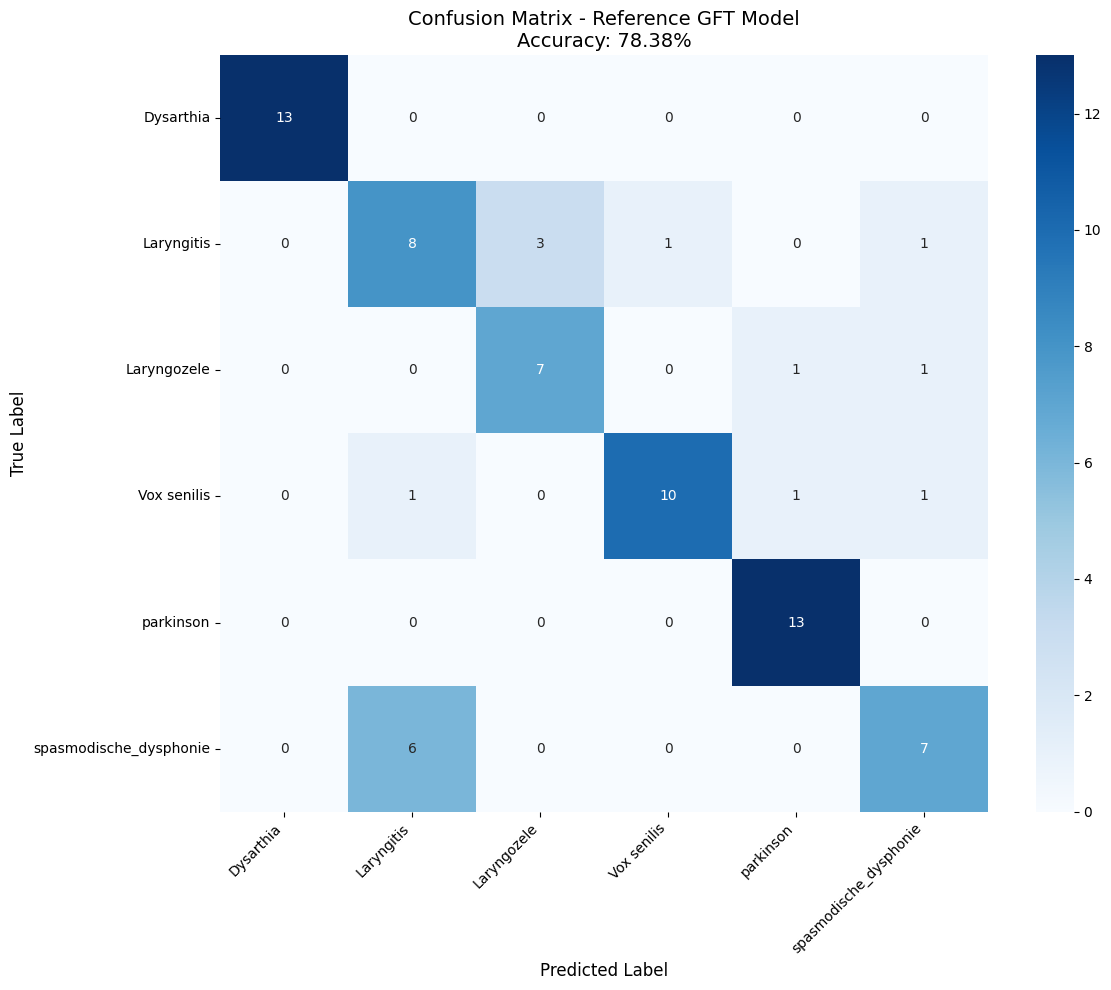

In [7]:
# =============================================================================
# GFT (Reference Architecture) EVALUATION Script for MelSpectrograms
#
# Loads the trained 'best_gft_melspectrogram.pth' and evaluates it on the test set.
# =============================================================================
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from timm import create_model
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# 1. MODEL ARCHITECTURE (Must be included to load the saved model weights)
# =============================================================================
class HierarchicalAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.smooth = nn.Conv1d(1, 1, kernel_size=3, padding=1, bias=False)
        nn.init.ones_(self.smooth.weight)
        self.ema_alpha = 0.9
        self.register_buffer('ema_grad', None, persistent=False)
    def compute_gradient_attention(self, attn_scores):
        B, H, N, _ = attn_scores.shape
        mean_attn = attn_scores.mean(dim=-1)
        grad = torch.zeros_like(mean_attn)
        grad[:, :, 1:-1] = (mean_attn[:, :, 2:] - mean_attn[:, :, :-2]) / 2.0
        grad[:, :, 0] = mean_attn[:, :, 1] - mean_attn[:, :, 0]
        grad[:, :, -1] = mean_attn[:, :, -1] - mean_attn[:, :, -2]
        importance_scores = grad.abs().mean(dim=1)
        importance_scores = self.smooth(importance_scores.unsqueeze(1)).squeeze(1)
        importance_scores = (importance_scores - importance_scores.mean(dim=-1, keepdim=True)) / (importance_scores.std(dim=-1, keepdim=True) + 1e-6)
        if self.training:
            if self.ema_grad is None or self.ema_grad.shape != importance_scores.shape: self.ema_grad = importance_scores.detach()
            else: self.ema_grad = self.ema_alpha * self.ema_grad + (1 - self.ema_alpha) * importance_scores.detach()
            importance_scores = 0.5 * (importance_scores + self.ema_grad)
        return torch.softmax(importance_scores / 0.1, dim=-1)
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn_raw = attn.clone().detach()
        attn = attn.softmax(dim=-1)
        patch_importance = self.compute_gradient_attention(attn_raw)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, patch_importance

class GFT(nn.Module):
    def __init__(self, base_model='vit_base_patch16_224', num_classes=10, patch_size=16, img_size=224):
        super().__init__()
        self.base_model = create_model(base_model, pretrained=True)
        embed_dim = self.base_model.embed_dim
        self.num_patches = (img_size // patch_size) ** 2
        self.hierarchical_blocks = nn.ModuleList([HierarchicalAttention(dim=embed_dim, num_heads=12) for _ in range(3)])
        num_ftrs = self.base_model.head.in_features
        self.base_model.head = nn.Identity()
        self.classifier = nn.Linear(num_ftrs, num_classes)
        self.selection_sizes = [int(self.num_patches * r) for r in [0.75, 0.5, 0.25]]
    def select_patches(self, tokens, importance, k):
        B, N = tokens.shape[0], importance.shape[1]
        k = min(k, N)
        _, top_k_idx = torch.topk(importance, k, dim=1)
        batch_idx = torch.arange(B, device=tokens.device).unsqueeze(1)
        return tokens[batch_idx, top_k_idx]
    def forward(self, x):
        x = self.base_model.patch_embed(x)
        cls_token = self.base_model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.base_model.pos_drop(x + self.base_model.pos_embed)
        for blk in self.base_model.blocks[:8]: x = blk(x)
        final_cls_before_pruning = x[:, 0]
        current_tokens = x[:, 1:]
        for attn_block, select_size in zip(self.hierarchical_blocks, self.selection_sizes):
            tokens_attn, importance = attn_block(current_tokens)
            current_tokens = self.select_patches(tokens_attn, importance, select_size)
        logits = self.classifier(final_cls_before_pruning)
        return logits

# =============================================================================
# 2. MAIN EVALUATION BLOCK
# =============================================================================
if __name__ == '__main__':
    # --- Configuration ---
    # ⚠️ **UPDATE these paths** as needed
    DATA_DIR = "melspectrograms_dataset/"
    MODEL_PATH = "best_gft_melspectrogram.pth"
    
    IMG_SIZE = 224
    BATCH_SIZE = 32
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # --- Data Transforms ---
    test_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # --- Dataset and DataLoader ---
    test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'test'), transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    num_classes = len(test_dataset.classes)
    class_names = test_dataset.classes
    print(f"Found {len(test_dataset)} test images belonging to {num_classes} classes.")

    # --- Model Loading ---
    model = GFT(num_classes=num_classes, img_size=IMG_SIZE).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print(f"Model loaded successfully from: {MODEL_PATH}")

    # --- Inference Loop ---
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            images = images.to(DEVICE)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Metrics Calculation and Display ---
    print("\n" + "="*50)
    print("           REFERENCE GFT - EVALUATION RESULTS")
    print("="*50)

    # 1. Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n🎯 Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # 2. Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0))

    # 3. Confusion Matrix
    print("\n📈 Plotting Confusion Matrix...")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Reference GFT Model\nAccuracy: {accuracy:.2%}', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()